VWAP ALGO PERFORMANCE ANALYSIS

✓ Generated dummy data:
  - 200 orders
  - 2000 fills

CALCULATING SLIPPAGE COMPONENTS

✓ Slippage components calculated

OVERALL PERFORMANCE METRICS

                      Metric      Value
Avg Implementation Shortfall 786.83 bps
        Avg Arrival Slippage 859.80 bps
           Avg VWAP Slippage 782.88 bps
            Avg Market Drift  72.98 bps
                                       
             Avg Spread Cost  -0.02 bps
              Avg Delay Cost 606.20 bps
             Avg Timing Cost 180.65 bps
       Avg Adverse Selection  -0.01 bps
                                       
       Avg Passive Fill Rate     50.7 %
      Avg Order Size (% ADV)     15.0 %
                Total Orders        200

QUARTILE ANALYSIS BY IMPLEMENTATION SHORTFALL

              Count  Impl Shortfall  Spread Cost  Passive Rate %  Adverse Selection  % ADV  Timing Cost
implQuartile                                                                                           
Q

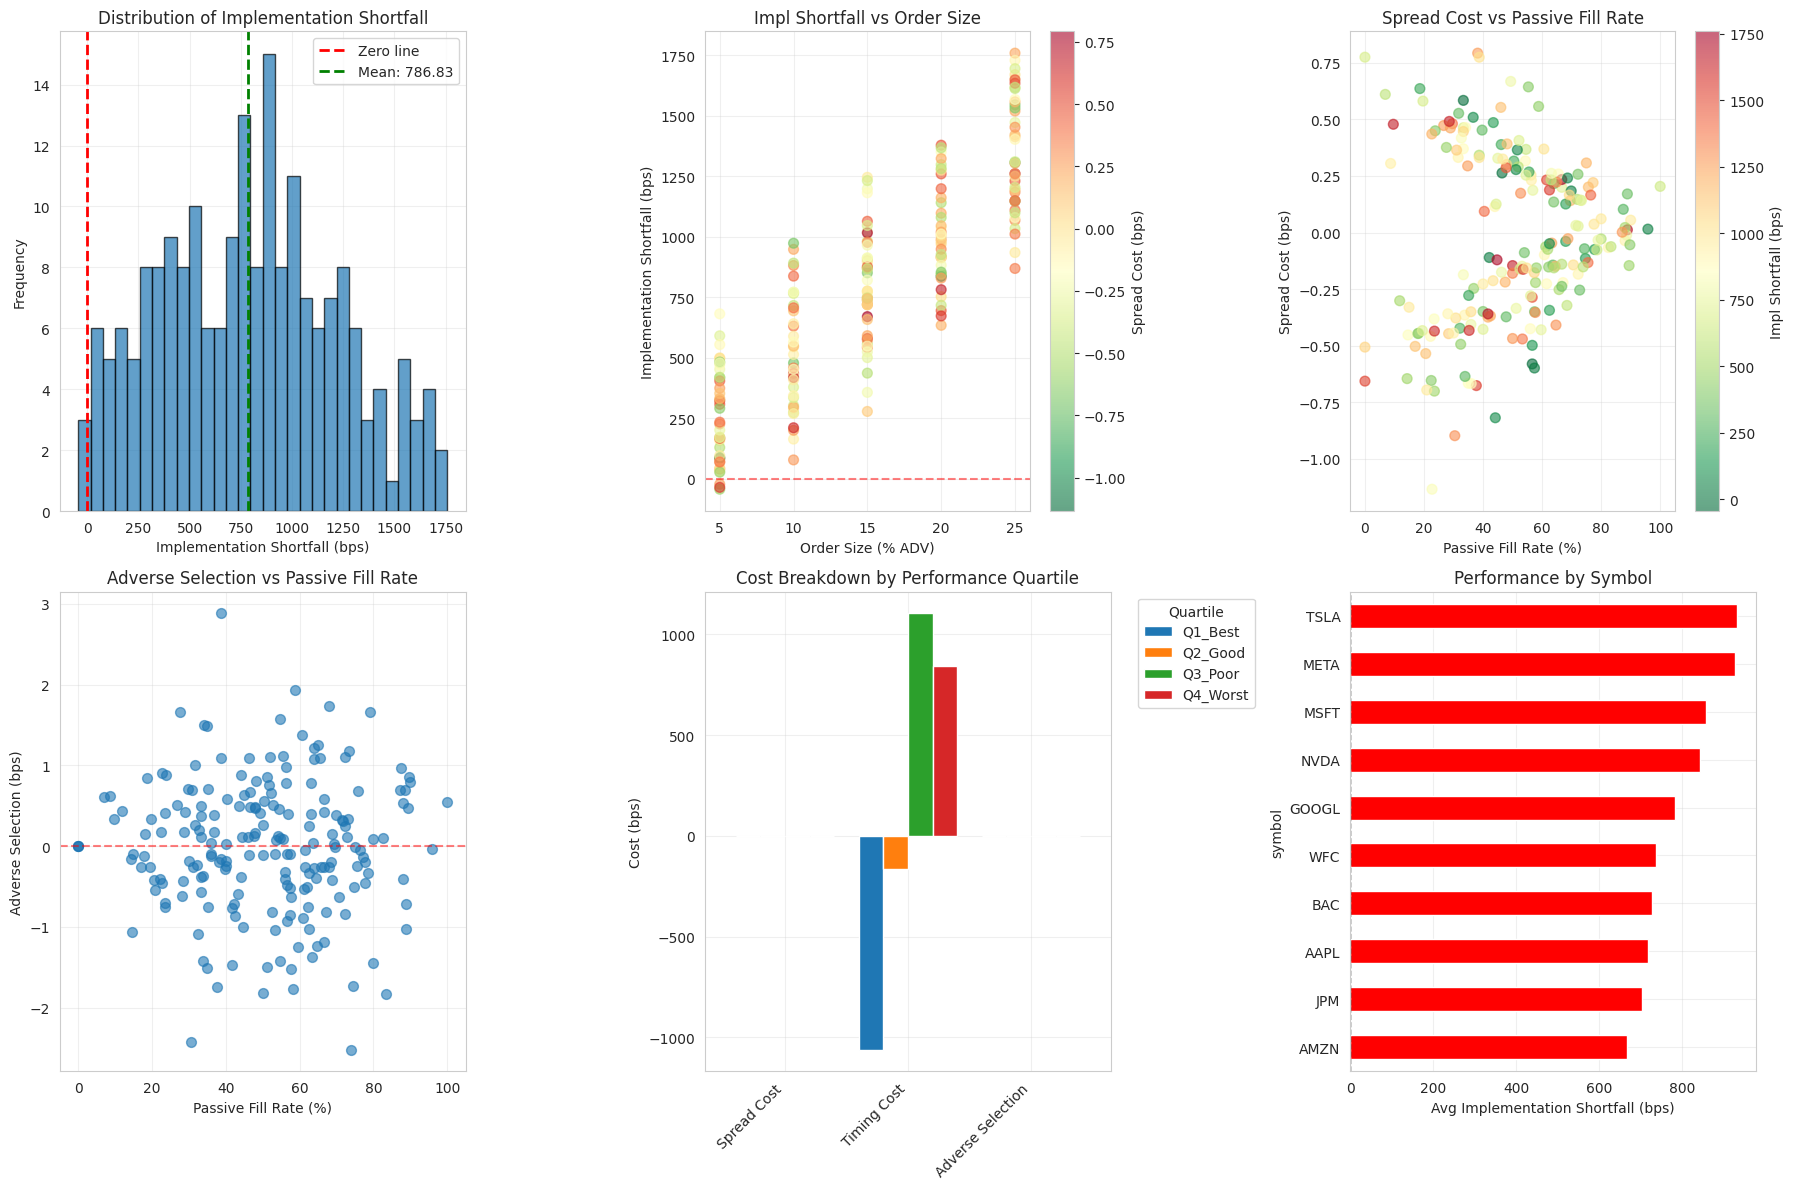

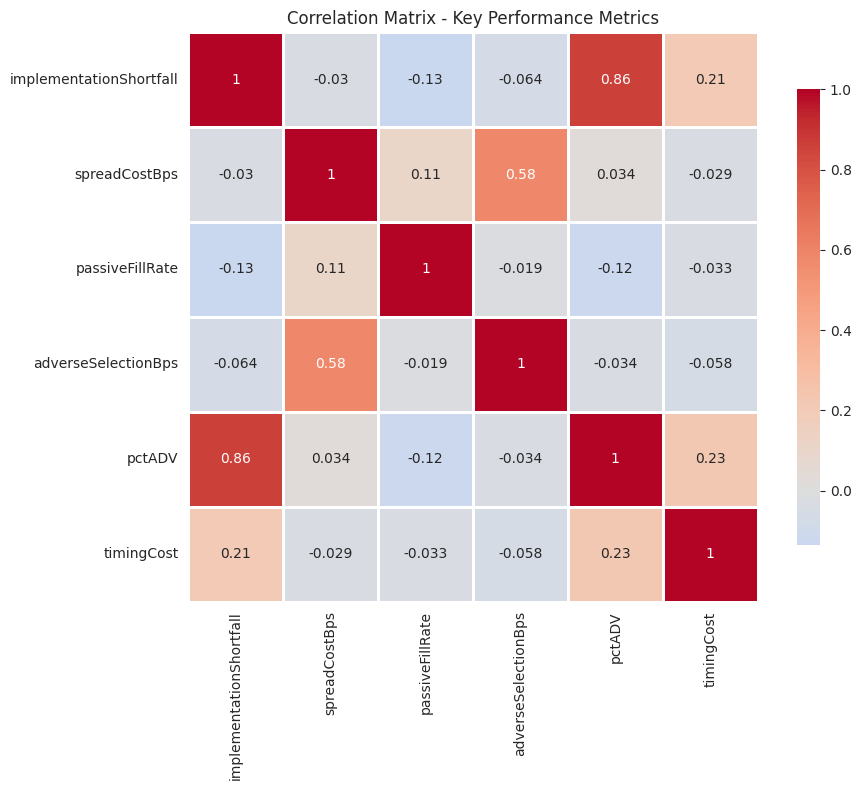

In [1]:
"""
VWAP Algo Performance Analysis
Slippage Decomposition and Diagnostic Analysis
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("VWAP ALGO PERFORMANCE ANALYSIS")
print("="*60)

# ============================================================================
# 1. GENERATE DUMMY DATA
# ============================================================================

np.random.seed(42)
n_orders = 200

# Generate order-level data
orders = pd.DataFrame({
    'orderID': range(1000, 1000 + n_orders),
    'date': pd.date_range('2024-07-01', periods=n_orders, freq='D')[:n_orders],
    'symbol': np.random.choice(['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'BAC', 'WFC'], n_orders),
    'side': np.random.choice(['BUY', 'SELL'], n_orders),
    'shares': np.random.choice([10000, 20000, 50000, 100000, 200000], n_orders),
    'arrivalTime': '09:00:00',
    'arrivalPrice': 100 + np.random.uniform(10, 150, n_orders),
    'orderDuration': np.random.choice([360, 390, 420], n_orders),  # minutes
    'pctADV': np.random.choice([5.0, 10.0, 15.0, 20.0, 25.0], n_orders),
    'completionRate': 95.0 + np.random.uniform(0, 5, n_orders)
})

# Add realistic correlations
orders['execVWAP'] = (orders['arrivalPrice'] +
                      (0.5 * orders['pctADV'] * 0.01 * orders['arrivalPrice']) +
                      np.random.uniform(-0.02, 0.04, n_orders) * orders['arrivalPrice'])

orders['benchmarkVWAP'] = (orders['arrivalPrice'] +
                           np.random.uniform(-0.015, 0.03, n_orders) * orders['arrivalPrice'])

# Generate fill-level data
n_fills = 2000
fills = pd.DataFrame({
    'fillID': range(n_fills),
    'orderID': np.random.choice(orders['orderID'], n_fills),
    'fillTime': ['09:00:00'] * n_fills,  # Will add random offsets
    'fillShares': np.random.choice([500, 1000, 2000, 5000], n_fills),
    'bid': 100 + np.random.uniform(10, 150, n_fills),
    'isPassive': np.random.choice([True, False], n_fills),
    'venue': np.random.choice(['NASDAQ', 'NYSE', 'BATS', 'IEX', 'EDGX'], n_fills)
})

# Make realistic spreads
fills['ask'] = fills['bid'] + 0.01 + np.random.uniform(0, 0.05, n_fills)
fills['fillPrice'] = np.where(
    fills['isPassive'],
    fills['bid'] + (fills['ask'] - fills['bid']) * (0.3 + np.random.uniform(0, 0.3, n_fills)),
    fills['bid'] + (fills['ask'] - fills['bid']) * (0.7 + np.random.uniform(0, 0.3, n_fills))
)

print("\n✓ Generated dummy data:")
print(f"  - {len(orders)} orders")
print(f"  - {len(fills)} fills")

# ============================================================================
# 2. SLIPPAGE DECOMPOSITION CALCULATIONS
# ============================================================================

print("\n" + "="*60)
print("CALCULATING SLIPPAGE COMPONENTS")
print("="*60)

# Basic slippage metrics
orders['arrivalSlippage'] = 10000 * (orders['execVWAP'] - orders['arrivalPrice']) / orders['arrivalPrice']
orders['vwapSlippage'] = 10000 * (orders['execVWAP'] - orders['benchmarkVWAP']) / orders['benchmarkVWAP']
orders['marketDrift'] = 10000 * (orders['benchmarkVWAP'] - orders['arrivalPrice']) / orders['arrivalPrice']

# Implementation shortfall (your performance vs benchmark)
orders['implementationShortfall'] = orders['arrivalSlippage'] - orders['marketDrift']

# Calculate first fill metrics
firstFills = fills.groupby('orderID').agg({
    'fillPrice': 'first',
    'fillTime': 'first'
}).reset_index()
firstFills.columns = ['orderID', 'firstFillPrice', 'firstFillTime']

orders = orders.merge(firstFills, on='orderID', how='left')
orders['delayCost'] = 10000 * (orders['firstFillPrice'] - orders['arrivalPrice']) / orders['arrivalPrice']
orders['delayCost'] = orders['delayCost'].fillna(0)

# Calculate spread costs
fills['midAtFill'] = (fills['bid'] + fills['ask']) / 2
fills = fills.merge(orders[['orderID', 'side', 'arrivalPrice']], on='orderID', how='left')
fills['spreadCostPerFill'] = fills['fillPrice'] - fills['midAtFill']
fills['spreadCostPerFill'] = np.where(
    fills['side'] == 'SELL',
    -fills['spreadCostPerFill'],
    fills['spreadCostPerFill']
)

# Aggregate spread cost to order level
spreadCosts = fills.groupby('orderID').apply(
    lambda x: pd.Series({
        'totalSpreadCost': (x['spreadCostPerFill'] * x['fillShares']).sum(),
        'totalFillShares': x['fillShares'].sum()
    })
).reset_index()

orders = orders.merge(spreadCosts, on='orderID', how='left')
orders['spreadCostBps'] = 10000 * orders['totalSpreadCost'] / orders['totalFillShares'] / orders['arrivalPrice']
orders['spreadCostBps'] = orders['spreadCostBps'].fillna(0)

# Calculate passive fill rate
passiveStats = fills.groupby('orderID').apply(
    lambda x: pd.Series({
        'passiveShares': x.loc[x['isPassive'], 'fillShares'].sum(),
        'totalFillShares': x['fillShares'].sum()
    })
).reset_index()

orders = orders.merge(passiveStats[['orderID', 'passiveShares']], on='orderID', how='left')
orders['passiveFillRate'] = 100 * orders['passiveShares'] / orders['totalFillShares']
orders['passiveFillRate'] = orders['passiveFillRate'].fillna(0)

# Calculate adverse selection on passive fills
passiveFills = fills[fills['isPassive']].copy()
passiveFills['priceAfter1min'] = passiveFills['fillPrice'] + np.random.uniform(-0.02, 0.04, len(passiveFills))
passiveFills['adverseSelectionPerFill'] = np.where(
    passiveFills['side'] == 'BUY',
    passiveFills['priceAfter1min'] - passiveFills['fillPrice'],
    passiveFills['fillPrice'] - passiveFills['priceAfter1min']
)

adverseSelection = passiveFills.groupby('orderID').apply(
    lambda x: (x['adverseSelectionPerFill'] * x['fillShares']).sum() / x['fillShares'].sum()
).reset_index()
adverseSelection.columns = ['orderID', 'avgAdverseSelection']

orders = orders.merge(adverseSelection, on='orderID', how='left')
orders['adverseSelectionBps'] = 10000 * orders['avgAdverseSelection'] / orders['arrivalPrice']
orders['adverseSelectionBps'] = orders['adverseSelectionBps'].fillna(0)

# Calculate timing cost (residual)
orders['timingCost'] = orders['implementationShortfall'] - orders['spreadCostBps'] - orders['delayCost']

print("\n✓ Slippage components calculated")

# ============================================================================
# 3. SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*60)
print("OVERALL PERFORMANCE METRICS")
print("="*60)

summary = pd.DataFrame({
    'Metric': [
        'Avg Implementation Shortfall',
        'Avg Arrival Slippage',
        'Avg VWAP Slippage',
        'Avg Market Drift',
        '',
        'Avg Spread Cost',
        'Avg Delay Cost',
        'Avg Timing Cost',
        'Avg Adverse Selection',
        '',
        'Avg Passive Fill Rate',
        'Avg Order Size (% ADV)',
        'Total Orders'
    ],
    'Value': [
        f"{orders['implementationShortfall'].mean():.2f} bps",
        f"{orders['arrivalSlippage'].mean():.2f} bps",
        f"{orders['vwapSlippage'].mean():.2f} bps",
        f"{orders['marketDrift'].mean():.2f} bps",
        '',
        f"{orders['spreadCostBps'].mean():.2f} bps",
        f"{orders['delayCost'].mean():.2f} bps",
        f"{orders['timingCost'].mean():.2f} bps",
        f"{orders['adverseSelectionBps'].mean():.2f} bps",
        '',
        f"{orders['passiveFillRate'].mean():.1f} %",
        f"{orders['pctADV'].mean():.1f} %",
        f"{len(orders)}"
    ]
})

print("\n" + summary.to_string(index=False))

# ============================================================================
# 4. QUARTILE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("QUARTILE ANALYSIS BY IMPLEMENTATION SHORTFALL")
print("="*60)

orders['implQuartile'] = pd.qcut(
    orders['implementationShortfall'],
    q=4,
    labels=['Q1_Best', 'Q2_Good', 'Q3_Poor', 'Q4_Worst']
)

quartileAnalysis = orders.groupby('implQuartile').agg({
    'orderID': 'count',
    'implementationShortfall': 'mean',
    'spreadCostBps': 'mean',
    'passiveFillRate': 'mean',
    'adverseSelectionBps': 'mean',
    'pctADV': 'mean',
    'timingCost': 'mean'
}).round(2)

quartileAnalysis.columns = ['Count', 'Impl Shortfall', 'Spread Cost',
                            'Passive Rate %', 'Adverse Selection',
                            '% ADV', 'Timing Cost']

print("\n" + quartileAnalysis.to_string())

# Compare best vs worst
print("\n" + "="*60)
print("TOP vs BOTTOM QUARTILE COMPARISON")
print("="*60)

q1 = orders[orders['implQuartile'] == 'Q1_Best']
q4 = orders[orders['implQuartile'] == 'Q4_Worst']

comparison = pd.DataFrame({
    'Metric': ['Impl Shortfall', 'Spread Cost', 'Passive Rate',
               'Adverse Selection', '% ADV', 'Timing Cost'],
    'Q1 (Best)': [
        q1['implementationShortfall'].mean(),
        q1['spreadCostBps'].mean(),
        q1['passiveFillRate'].mean(),
        q1['adverseSelectionBps'].mean(),
        q1['pctADV'].mean(),
        q1['timingCost'].mean()
    ],
    'Q4 (Worst)': [
        q4['implementationShortfall'].mean(),
        q4['spreadCostBps'].mean(),
        q4['passiveFillRate'].mean(),
        q4['adverseSelectionBps'].mean(),
        q4['pctADV'].mean(),
        q4['timingCost'].mean()
    ]
})
comparison['Difference'] = comparison['Q4 (Worst)'] - comparison['Q1 (Best)']
comparison = comparison.round(2)

print("\n" + comparison.to_string(index=False))

# ============================================================================
# 5. SIZE CATEGORY ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("PERFORMANCE BY ORDER SIZE")
print("="*60)

orders['sizeCategory'] = pd.cut(
    orders['pctADV'],
    bins=[0, 10, 20, 100],
    labels=['Small (<10%)', 'Medium (10-20%)', 'Large (>20%)']
)

sizeAnalysis = orders.groupby('sizeCategory').agg({
    'orderID': 'count',
    'pctADV': 'mean',
    'implementationShortfall': 'mean',
    'spreadCostBps': 'mean',
    'passiveFillRate': 'mean',
    'adverseSelectionBps': 'mean'
}).round(2)

sizeAnalysis.columns = ['Count', 'Avg % ADV', 'Impl Shortfall',
                        'Spread Cost', 'Passive Rate %', 'Adverse Selection']

print("\n" + sizeAnalysis.to_string())

# ============================================================================
# 6. WORST PERFORMING ORDERS
# ============================================================================

print("\n" + "="*60)
print("TOP 10 WORST PERFORMING ORDERS")
print("="*60)

worstOrders = orders.nsmallest(10, 'implementationShortfall')[
    ['orderID', 'symbol', 'date', 'shares', 'pctADV',
     'implementationShortfall', 'spreadCostBps', 'passiveFillRate',
     'adverseSelectionBps', 'timingCost']
].round(2)

print("\n" + worstOrders.to_string(index=False))

# ============================================================================
# 7. VISUALIZATIONS
# ============================================================================

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Implementation Shortfall Distribution
ax = axes[0, 0]
ax.hist(orders['implementationShortfall'], bins=30, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero line')
ax.axvline(orders['implementationShortfall'].mean(), color='green',
           linestyle='--', linewidth=2, label=f'Mean: {orders["implementationShortfall"].mean():.2f}')
ax.set_xlabel('Implementation Shortfall (bps)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Implementation Shortfall')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Implementation Shortfall vs Order Size
ax = axes[0, 1]
scatter = ax.scatter(orders['pctADV'], orders['implementationShortfall'],
                     alpha=0.6, c=orders['spreadCostBps'], cmap='RdYlGn_r', s=50)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Order Size (% ADV)')
ax.set_ylabel('Implementation Shortfall (bps)')
ax.set_title('Impl Shortfall vs Order Size')
plt.colorbar(scatter, ax=ax, label='Spread Cost (bps)')
ax.grid(True, alpha=0.3)

# 3. Spread Cost vs Passive Fill Rate
ax = axes[0, 2]
scatter = ax.scatter(orders['passiveFillRate'], orders['spreadCostBps'],
                     alpha=0.6, s=50, c=orders['implementationShortfall'], cmap='RdYlGn_r')
ax.set_xlabel('Passive Fill Rate (%)')
ax.set_ylabel('Spread Cost (bps)')
ax.set_title('Spread Cost vs Passive Fill Rate')
plt.colorbar(scatter, ax=ax, label='Impl Shortfall (bps)')
ax.grid(True, alpha=0.3)

# 4. Adverse Selection vs Passive Rate
ax = axes[1, 0]
ax.scatter(orders['passiveFillRate'], orders['adverseSelectionBps'],
           alpha=0.6, s=50)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Passive Fill Rate (%)')
ax.set_ylabel('Adverse Selection (bps)')
ax.set_title('Adverse Selection vs Passive Fill Rate')
ax.grid(True, alpha=0.3)

# 5. Cost Breakdown by Quartile
ax = axes[1, 1]
cost_data = quartileAnalysis[['Spread Cost', 'Timing Cost', 'Adverse Selection']].T
cost_data.plot(kind='bar', ax=ax, width=0.8)
ax.set_ylabel('Cost (bps)')
ax.set_title('Cost Breakdown by Performance Quartile')
ax.legend(title='Quartile', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# 6. Performance by Symbol
ax = axes[1, 2]
symbolPerf = orders.groupby('symbol')['implementationShortfall'].mean().sort_values()
symbolPerf.plot(kind='barh', ax=ax, color=['green' if x < 0 else 'red' for x in symbolPerf])
ax.axvline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Avg Implementation Shortfall (bps)')
ax.set_title('Performance by Symbol')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vwap_analysis_summary.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualizations saved as 'vwap_analysis_summary.png'")

# ============================================================================
# 8. CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

corr_cols = ['implementationShortfall', 'spreadCostBps', 'passiveFillRate',
             'adverseSelectionBps', 'pctADV', 'timingCost']
correlation_matrix = orders[corr_cols].corr().round(3)

print("\n" + correlation_matrix.to_string())

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Key Performance Metrics')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Correlation matrix saved as 'correlation_matrix.png'")

# ============================================================================
# 9. KEY INSIGHTS
# ============================================================================

print("\n" + "="*60)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("="*60)

insights = []

# Check implementation shortfall
if orders['implementationShortfall'].mean() > 2:
    insights.append("⚠ CRITICAL: Avg implementation shortfall is +{:.2f} bps (underperforming benchmark)".format(
        orders['implementationShortfall'].mean()))
elif orders['implementationShortfall'].mean() > 0:
    insights.append("⚠ WARNING: Slight underperformance vs benchmark (+{:.2f} bps)".format(
        orders['implementationShortfall'].mean()))
else:
    insights.append("✓ GOOD: Outperforming benchmark by {:.2f} bps".format(
        abs(orders['implementationShortfall'].mean())))

# Check spread cost
if orders['spreadCostBps'].mean() > 3:
    insights.append("⚠ High spread costs ({:.2f} bps) - consider being more passive".format(
        orders['spreadCostBps'].mean()))

# Check adverse selection
if orders['adverseSelectionBps'].mean() < -1:
    insights.append("⚠ Significant adverse selection ({:.2f} bps) - getting picked off on passive orders".format(
        orders['adverseSelectionBps'].mean()))

# Check quartile differences
q_diff = comparison[comparison['Metric'] == 'Impl Shortfall']['Difference'].values[0]
if abs(q_diff) > 10:
    insights.append("⚠ Large performance variance between best/worst orders ({:.2f} bps gap)".format(q_diff))

# Check size impact
if correlation_matrix.loc['implementationShortfall', 'pctADV'] > 0.3:
    insights.append("⚠ Strong correlation between order size and poor performance - impact management issue")

for i, insight in enumerate(insights, 1):
    print(f"\n{i}. {insight}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("\nNext Steps:")
print("1. Deep dive into worst performing orders")
print("2. Analyze intraday participation patterns")
print("3. Compare against peer broker performance")
print("4. Test parameter adjustments (passive %, urgency levels)")
print("="*60)